In [1]:
import numpy as np
import pandas as pd
import sys,os
import random
import copy

import matplotlib.pyplot as plt
import seaborn as sns

from run_desmond import run_DESMOND
from utils.eval import find_best_matches, generate_exprs

# Simulated expression data 

* 10000 genes x 200 samples
* background ~N(0,1), bicluster ~ N(4,1)
* four biclusters with fraction [0.05,0.1,0.25,0.5] of all samples simulate four subtypes
* three scenarios A,B,C
    * for each scenario, bicluster sizes in genes were 5,50,500 
    * 3 scenarios x 3 gene sizes = 9 expression matrices in total

### scenario A:
 * biclusters are not overlapping in genes and samples
 * all other genes are independent  ~N(0,1)

### scenario B:
 * biclusters are overlapping in genes and samples
 * all other genes are independent  ~N(0,1)

### scenario C:
 * overlapping in genes and samples
 * four co-expressed modules of 500 genes each
 

In [43]:
df = pd.read_csv("data/simulated_m=4,std=1/A/A.n_genes=500.exprs_z.tsv",sep = "\t",index_col=0)

up_genes = list(np.random.choice(list(df.index.values),size=200,replace=False))
df.loc[up_genes,:] = df.loc[up_genes,:]+pd.DataFrame(np.random.normal(loc=1,scale=1,size = (200,200 ))).values
down_genes = list(np.random.choice(list(df.index.values),size=100,replace=False))
df.loc[down_genes,:] = df.loc[down_genes,:]-pd.DataFrame(np.random.normal(loc=2,scale=1,size = (100,200 ))).values

df.to_csv("disease_expressions.tsv",sep = "\t")

In [44]:
df_n = d.DataFrame(np.random.normal(loc=0,scale=1.0,size = (10000,150 ))) 
df_n.index = df.index.values
df_n.columns = ["s_"+str(x+200) for x in df_n.columns.values ]
df_n.to_csv("controls_expressions.tsv",sep = "\t")

(10000, 350)


/home/olya/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


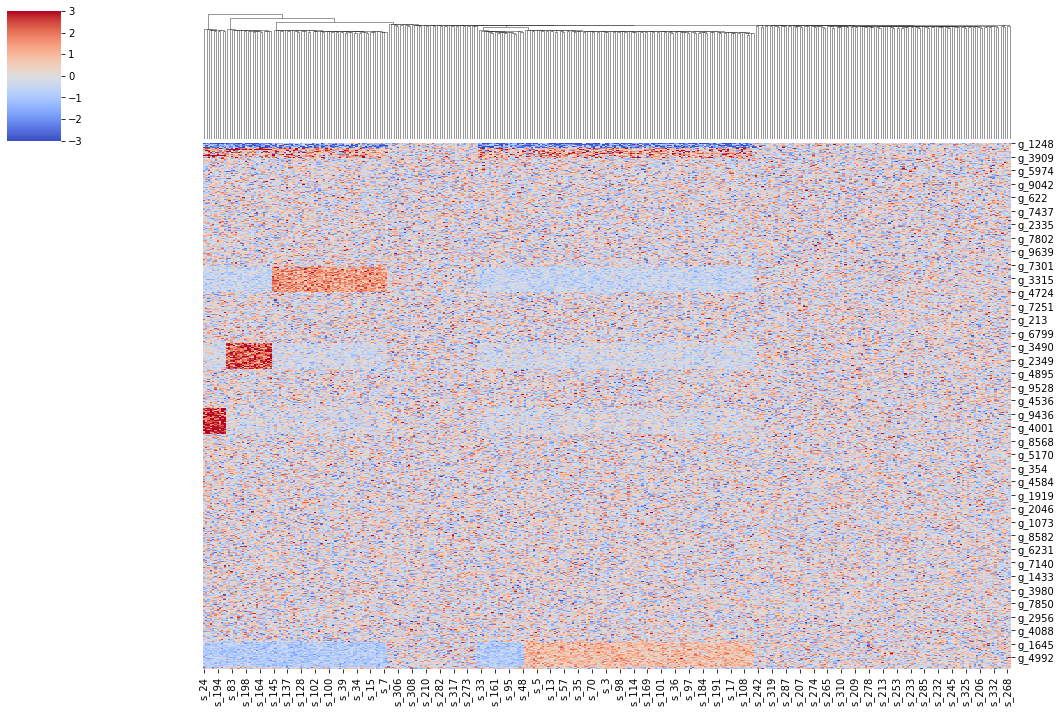

In [47]:
df = pd.read_csv("disease_expressions.tsv",sep = "\t",index_col = 0)
df_n = pd.read_csv("controls_expressions.tsv",sep = "\t",index_col = 0)
df = pd.concat([df, df_n ],axis=1)
print(df.shape)
cg = sns.clustermap(df,row_cluster=True,col_cluster=True, figsize=(15,10),
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3)
cg.ax_row_dendrogram.set_visible(False)

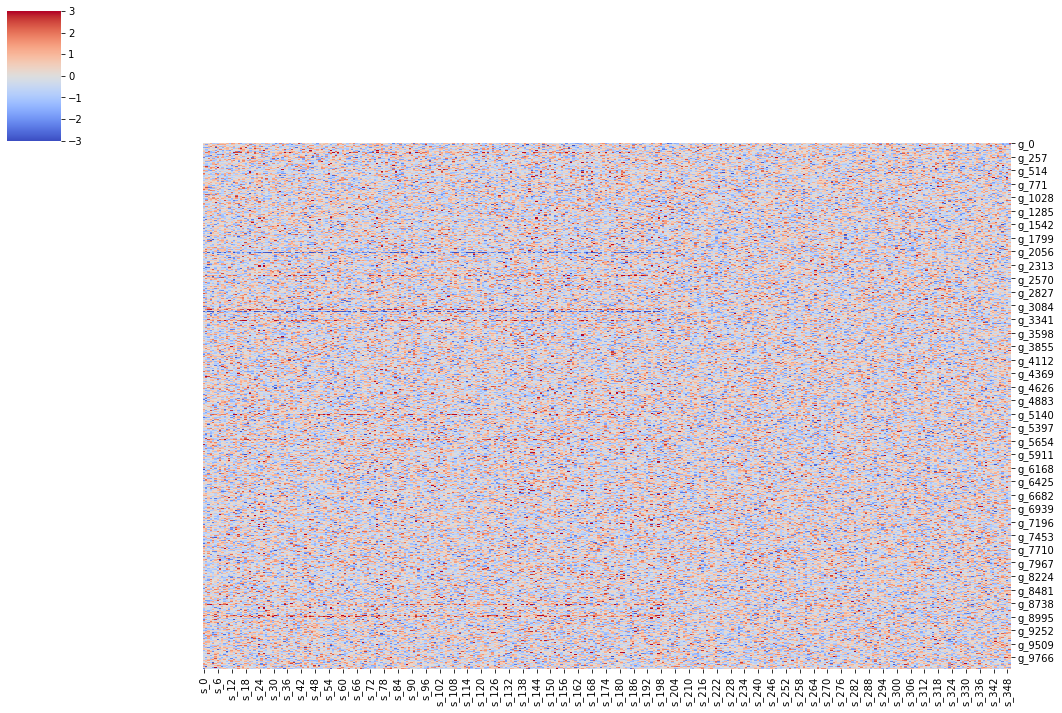

In [48]:
cg = sns.clustermap(df,row_cluster=False,col_cluster=False, figsize=(15,10),
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3)
cg.ax_row_dendrogram.set_visible(False)

# In this example, scenario C with 500-gene biclusters is shown

	co-exprs. module  500 r= 0.5468411740537167
	co-exprs. module  500 r= 0.5202936259436477
	co-exprs. module  500 r= 0.5448536662009368
	co-exprs. module  500 r= 0.5329295094922204
expressions: data/simulated//C.n_genes=5,m=4,std=1,overlap=yes.exprs_z.tsv
true bilusters: data/simulated//C.n_genes=5,m=4,std=1,overlap=yes.biclusters.tsv
	co-exprs. module  500 r= 0.41766450490798646
	co-exprs. module  500 r= 0.45405946648762413
	co-exprs. module  500 r= 0.5813641688085625
	co-exprs. module  500 r= 0.5528833611528654
expressions: data/simulated//C.n_genes=50,m=4,std=1,overlap=yes.exprs_z.tsv
true bilusters: data/simulated//C.n_genes=50,m=4,std=1,overlap=yes.biclusters.tsv
	co-exprs. module  500 r= 0.5454648560433878
	co-exprs. module  500 r= 0.5287039898057091
	co-exprs. module  500 r= 0.46019523767762816
	co-exprs. module  500 r= 0.5812119776013125
expressions: data/simulated//C.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv
true bilusters: data/simulated//C.n_genes=500,m=4,std=1,overlap=ye

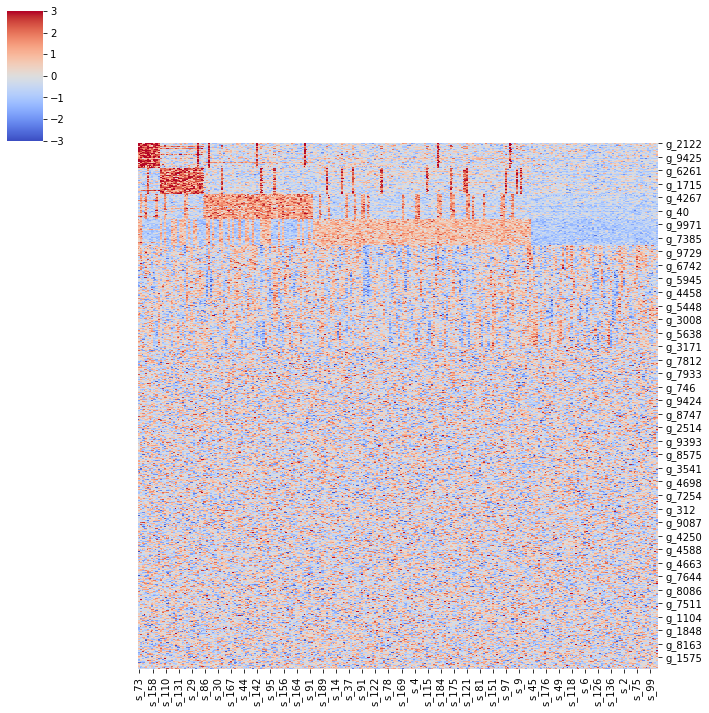

In [2]:
# background expressions N(0,1)
seed = 42
n_genes = 10000
N = 200


# genes,percent_of_samples
frac_samples = [0.05,0.1,0.25,0.5] #10,20,50,100

outdir = "data/simulated/"
outfile_basename="C"

m = 4
std = 1


for gene_size in [5,50,500]:
    exprs, ground_truth,coexpressed_modules = generate_exprs((n_genes,N),g_size=gene_size,frac_samples=[0.05,0.1,0.25,0.5],m=m,std=std,
                           outdir = outdir,outfile_basename=outfile_basename, 
                           g_overlap=True,s_overlap=True,
                           seed = seed, add_coexpressed = [500]*4)#add_coexpressed = [500]*4





bic_g = []
bic_s = []
for row in ground_truth.iterrows():
    bic = row[1]
    g = list(bic["genes"])
    s = list(bic["samples"])
    bic_g += g
    bic_s += s
    
for module in coexpressed_modules:
    bic_g +=  module
    
bg_g = set(exprs.index.values).difference(set(bic_g))
bg_s = set(exprs.columns.values).difference(set(bic_s))

samples = bic_s + list(bg_s)
genes = bic_g + list(bg_g)
cg = sns.clustermap(exprs.loc[genes,samples],row_cluster=False,col_cluster=False,
                    cmap=sns.color_palette("coolwarm", as_cmap=True),vmin=-3,vmax=3)
cg.ax_row_dendrogram.set_visible(False)

# Evaluation

In [2]:
# expression file
exprs_file = "data/simulated_m=4,std=1/C/C.n_genes=500.exprs_z.tsv" # "data/simulated/C/C.n_genes=500,m=4,std=1,overlap=yes.exprs_z.tsv"
exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)

# read ground truth from file
ground_truth_file = "data/simulated/C/C.n_genes=500,m=4,std=1,overlap=yes.biclusters.tsv"
ground_truth = pd.read_csv(ground_truth_file,sep ="\t",index_col=0)
ground_truth["samples"] = ground_truth["samples"].apply(lambda x: set(x.split(" ")))
if "genes" in ground_truth.columns.values:
    ground_truth["genes"] = ground_truth["genes"].apply(lambda x: set(x.split(" ")))

ground_truth

,genes,samples,frac,n_genes,n_samples:,n_samples
0.05,"{g_6199, g_6731, g_149, g_6443, g_2645, g_4150...","{s_46, s_185, s_194, s_26, s_75, s_131, s_144,...",0.05,500,10,10
0.10,"{g_7666, g_4338, g_2506, g_8298, g_2349, g_276...","{s_199, s_153, s_159, s_151, s_175, s_88, s_19...",0.10,500,20,20
0.25,"{g_8491, g_1759, g_656, g_9834, g_9542, g_5170...","{s_85, s_0, s_103, s_148, s_176, s_153, s_75, ...",0.25,500,50,50
0.50,"{g_656, g_9215, g_2402, g_3592, g_9071, g_1807...","{s_0, s_6, s_187, s_62, s_143, s_151, s_116, s...",0.50,500,100,100


In [3]:
# prepare a dict with sample groups corresponding to known bicluster
known_groups = {}
for group in ground_truth.index.values:
    known_groups[group] = ground_truth.loc[group,"samples"]

In [4]:
# run method - e.g. DESMOND
min_n_samples = 5
pval =0.0005
r = 1/3
bin_method = "GMM"
clust_method = "Louvain"
cluster_binary=False
out_dir = os.getcwd()+"/tmp_results/"
basename = "simulated" 

result = run_DESMOND(exprs_file, basename, out_dir="tmp_results/",  
                binarized_data = None, save=True, load = False,
                bin_method = bin_method, 
                clust_method = clust_method, cluster_binary=cluster_binary, 
                min_n_samples = min_n_samples, show_fits = [],
                pval = pval,
                r = r,
                seed = -1,
                verbose = True, plot_all = False)

seed= 784927
Read input from: data/simulated_m=4,std=1/C/C.n_genes=500.exprs_z.tsv
	10000 features x 200 samples
Mininal number of samples in a bicluster: 5

Binarization started ....

	Generate empirical distribuition of SNR depending on the bicluster size ...
		total samples: 200,
		number of samples in a bicluster: 5 - 100,
		n_permutations: 20001
snr_pval threshold: 0.0005


Input is standardized.
min_n_samples is recommended to be >= 10


			fraction: 0.1
	SNR thresholds for individual features computed in 1.55 seconds
	GMM method is chosen ...
		genes processed: 0
		genes processed: 1000
		genes processed: 2000
		genes processed: 3000
		genes processed: 4000
		genes processed: 5000
		genes processed: 6000
		genes processed: 7000
		genes processed: 8000
		genes processed: 9000
	GMM binarization for 10000 features completed in 49.61 s
	binarization runtime: 51.17 s
	1243 features passed binarization 
		UP-regulated features:	1172
		DOWN-regulated features:	124
		ambiguous features:	53
Statistics is saved to tmp_results//simulated.GMM.binarization_stats.tsv
Binarized gene expressions are saved to tmp_results//simulated.GMM.binarized_UP.tsv
Binarized gene expressions are saved to tmp_results//simulated.GMM.binarized_DOWN.tsv
	 modules: 4 not_clustered: 5
		modularity: 0.612 runtime: 0.08 s
	 modules: 4 not_clustered: 6
		modularity: 0.012 runtime: 0.01 s
tmp_results/simulated.bin=GMM,clust=Louvain.biclusters.tsv
Total runt

### Method output
* must be a dataFrame with (bi-)cluster index and "samples" coulum
* "samples" column contrain sets of samples

In [9]:
# DESMOND result
result

,gene_indexes,n_genes,sample_indexes,n_samples,avgSNR,direction,genes,samples
0,"[8460, 2645, 7364, 5668, 7900, 9112, 9083, 286...",27,"{194, 131, 197, 75, 46, 144, 55, 24, 185, 26}",10,2.508273,UP,"{g_8460, g_2645, g_7364, g_5668, g_7900, g_911...","{s_46, s_185, s_194, s_75, s_26, s_131, s_144,..."
1,"[6721, 6449, 5753, 8874, 3895, 4338, 4139, 471...",277,"{19, 21, 149, 151, 153, 159, 32, 40, 45, 175, ...",20,1.870706,UP,"{g_6721, g_6449, g_5753, g_8874, g_3895, g_433...","{s_199, s_153, s_159, s_175, s_151, s_88, s_19..."
2,"[2713, 5028, 6745, 7304, 3044, 1201, 3267, 286...",73,"{0, 2, 4, 6, 10, 11, 13, 17, 18, 19, 20, 25, 3...",100,1.727369,UP,"{g_2713, g_5028, g_6745, g_7304, g_3044, g_120...","{s_0, s_6, s_187, s_62, s_143, s_88, s_55, s_1..."
3,"[9215, 2402, 3592, 9071, 1807, 1835, 7120, 784...",404,"{0, 2, 4, 6, 10, 11, 13, 17, 18, 19, 20, 25, 3...",100,1.658686,UP,"{g_9215, g_2402, g_3592, g_9071, g_1807, g_183...","{s_0, s_6, s_187, s_62, s_143, s_88, s_55, s_1..."
4,"[8491, 1759, 9834, 9542, 5170, 3443, 2632, 148...",459,"{0, 130, 3, 132, 5, 134, 7, 13, 20, 148, 22, 2...",50,1.641918,UP,"{g_8491, g_1759, g_9834, g_9542, g_5170, g_344...","{s_85, s_0, s_103, s_148, s_176, s_153, s_75, ..."
5,"[6184, 3458, 1117, 8605, 6889, 9787, 6783, 473...",19,"{1, 3, 5, 7, 8, 9, 12, 14, 15, 16, 21, 22, 23,...",92,1.628561,DOWN,"{g_6184, g_3458, g_1117, g_8605, g_6889, g_978...","{s_78, s_199, s_140, s_165, s_91, s_7, s_125, ..."
6,"[9234, 4311, 3427, 7050, 2721, 2853, 3484, 329...",11,"{1, 3, 5, 7, 8, 9, 12, 14, 15, 16, 22, 23, 24,...",91,1.531794,DOWN,"{g_9234, g_4311, g_3427, g_7050, g_2721, g_285...","{s_78, s_140, s_197, s_165, s_7, s_125, s_43, ..."
7,"[7835, 4597, 3444, 3088, 888, 9572, 8013, 9731...",15,"{1, 131, 133, 8, 9, 137, 139, 12, 140, 14, 15,...",71,1.459562,DOWN,"{g_7835, g_4597, g_3444, g_3088, g_888, g_9572...","{s_146, s_180, s_199, s_139, s_142, s_27, s_78..."


# Finding best matches for each known sample cluster
* J - Jaccard similarity of known sample group and its best match
* J_weighted - Jaccard index proporional to bicluster size in terms of samples
* J total = sum(J_weighted) - betweem 0 and 1

In [10]:
all_samples = set(exprs.columns.values) # all samples in the expression file
best_matches = find_best_matches(result,known_groups,all_samples,FDR=0.05,verbose = False)
print("Total weighted J:",best_matches["J_weighted"].sum())
best_matches

Total weighted J: 1.0


,group_size,J,is_enriched,best_match_id,gene_indexes,n_genes,sample_indexes,n_samples,avgSNR,direction,genes,samples,J_weighted
known_group,,,,,,,,,,,,,
0.50,100,1.0,True,3,"[9215, 2402, 3592, 9071, 1807, 1835, 7120, 784...",404,"{0, 2, 4, 6, 10, 11, 13, 17, 18, 19, 20, 25, 3...",100,1.658686,UP,"{g_9215, g_2402, g_3592, g_9071, g_1807, g_183...","{s_0, s_6, s_187, s_62, s_143, s_88, s_55, s_1...",0.555556
0.25,50,1.0,True,4,"[8491, 1759, 9834, 9542, 5170, 3443, 2632, 148...",459,"{0, 130, 3, 132, 5, 134, 7, 13, 20, 148, 22, 2...",50,1.641918,UP,"{g_8491, g_1759, g_9834, g_9542, g_5170, g_344...","{s_85, s_0, s_103, s_148, s_176, s_153, s_75, ...",0.277778
0.10,20,1.0,True,1,"[6721, 6449, 5753, 8874, 3895, 4338, 4139, 471...",277,"{19, 21, 149, 151, 153, 159, 32, 40, 45, 175, ...",20,1.870706,UP,"{g_6721, g_6449, g_5753, g_8874, g_3895, g_433...","{s_199, s_153, s_159, s_175, s_151, s_88, s_19...",0.111111
0.05,10,1.0,True,0,"[8460, 2645, 7364, 5668, 7900, 9112, 9083, 286...",27,"{194, 131, 197, 75, 46, 144, 55, 24, 185, 26}",10,2.508273,UP,"{g_8460, g_2645, g_7364, g_5668, g_7900, g_911...","{s_46, s_185, s_194, s_75, s_26, s_131, s_144,...",0.055556


### Another example - k-means


In [11]:
from sklearn.cluster import KMeans

exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)

model = KMeans(n_clusters=4)
labels = model.fit_predict(exprs.T)


result2 = {}
sample_names = exprs.columns.values
for clust in set(labels):
    s = set(sample_names[labels == clust])
    result2[clust] = {"samples":s,"n_samples":len(s)}
result2 = pd.DataFrame.from_dict(result2).T
result2

,samples,n_samples
0,"{s_199, s_153, s_159, s_175, s_88, s_151, s_19...",20
1,"{s_66, s_150, s_18, s_93, s_127, s_6, s_80, s_...",70
2,"{s_85, s_0, s_103, s_148, s_176, s_75, s_115, ...",47
3,"{s_146, s_78, s_180, s_121, s_27, s_87, s_99, ...",63


In [12]:
best_matches2 = find_best_matches(result2,known_groups,all_samples,FDR=0.05)
print("Total weighted J:",best_matches2["J_weighted"].sum())
best_matches2

Total weighted J: 0.7611111111111111


,group_size,J,is_enriched,best_match_id,samples,n_samples,J_weighted
known_group,,,,,,,
0.50,100,0.7,True,1,"{s_66, s_150, s_18, s_93, s_127, s_6, s_80, s_...",70,0.388889
0.25,50,0.94,True,2,"{s_85, s_0, s_103, s_148, s_176, s_75, s_115, ...",47,0.261111
0.10,20,1.0,True,0,"{s_199, s_153, s_159, s_175, s_88, s_151, s_19...",20,0.111111
0.05,10.0,0.0,NaN,NaN,NaN,NaN,0.0


# Running DESMOND2 with multiple parameter combinations

In [13]:
def calc_performance(found_clusters, all_samples, ground_truth_file,match_unique=True):
    
    ground_truth = pd.read_csv(ground_truth_file,sep ="\t",index_col=0)
    ground_truth["samples"] = ground_truth["samples"].apply(lambda x: set(x.split(" ")))
    if "genes" in ground_truth.columns.values:
        ground_truth["genes"] = ground_truth["genes"].apply(lambda x: set(x.split(" ")))
        
    # prepare a dict with sample groups corresponding to known bicluster
    known_groups = {}
    known_gsets = {}
    for group in ground_truth.index.values:
        known_groups[group] = ground_truth.loc[group,"samples"]
        known_gsets[group] = ground_truth.loc[group,"genes"]
    
    if found_clusters is None:
        performance= {}
        performance["total"] = 0
        best_matches = None
    else:
        best_matches = find_best_matches(found_clusters,known_groups,all_samples,
                                         FDR=0.05,verbose = False,match_unique=match_unique)
        J_total = best_matches["J_weighted"].sum()
        performance = best_matches.loc[:,["J"]].to_dict()["J"]
        # renaming subtype-specific performances to "performance_"+subt
        subtypes = list(performance.keys())
        for subt in subtypes:
            performance["performance_"+str(subt)] = performance.pop(subt)
        performance["overall_performance"] = J_total
    return performance, best_matches


In [17]:
from time import time
from run_desmond2 import run_DESMOND

out_dir= "results_on_simulated_data/"
fname_prefix = "data/simulated_m=4,std=1/"

# number of runs and seeds - set to 5 
n_runs = 2
seeds =  [85822412, 14942603]# 3356886, 99529223, 36913810]

# method parameters to try
pvals = [0.0001] #[0.0001, 0.0005,0.001,0.005,0.01]
bin_methods = ["kmeans","ward"] 
modularities = [0.3,0.5]

df = []
for scenario in ["A"]: #,"B","C"]:
    for gsize in [500]: #,50,500]:
        exprs_file = fname_prefix + "/"+scenario+"/"+scenario+".n_genes="+str(gsize)+".exprs_z.tsv"
        ground_truth_file =fname_prefix + "/"+scenario+"/"+scenario+".n_genes="+str(gsize)+".biclusters.tsv"
        all_samples = set(pd.read_csv(exprs_file,sep="\t",index_col=0, nrows=0).columns.values)
        print(scenario,gsize)
        for run in range(n_runs):
            seed = seeds[run]
            for pval in pvals:
                for bin_method in bin_methods:
                    for m in modularities:
                        basename = scenario+".n_genes="+str(gsize)
                        try:
                            t0 = time()
                            # run the method
                            result, u,d = run_DESMOND(exprs_file, 
                                                     basename, out_dir=out_dir,
                                                     save=True, load = True,
                                                     ceiling =3,
                                                     bin_method = bin_method, pval = pval,
                                                     min_n_samples = 5, 
                                                     clust_method = "Louvain", 
                                                     cluster_binary=False,
                                                     #ds = ds, dch  = dch,
                                                     modularity=m,
                                                     seed = seed,
                                                     verbose = False, plot_all = False,
                                                     merge = 1)
                            # calculate performance and bmids
                            performance, best_matches = calc_performance(result, all_samples, ground_truth_file)
                            
                            # save parameters as a string
                            params = "bin_method="+bin_method+";pval="+str(pval)
                            params += ";clust_method="+"Louvain"+";modularity="+str(m)
                            print("\trun",run,params,performance)
                            
                            d = {"scenario":scenario,"gsize":gsize,
                                 "run":run,"seed":seed,
                                 "parameters":params}
                            d.update(performance)
                            d["runtime"] = time()-t0
                            df.append(d)
                        except:
                            print("\t failed",run,seed, params, file = sys.stderr)
                            
pd.DataFrame.from_records(df)

A 500
	Jaccard similarities for 6 features computed in 0.00 s.


merged biclustres [0, 1, 2]


	run 0 bin_method=kmeans;pval=0.0001;clust_method=Louvain;modularity=0.3 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 1.0, 'overall_performance': 1.0}
	Jaccard similarities for 6 features computed in 0.00 s.


merged biclustres [0, 1, 2]


	run 0 bin_method=kmeans;pval=0.0001;clust_method=Louvain;modularity=0.5 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 1.0, 'overall_performance': 1.0}
	Jaccard similarities for 9 features computed in 0.00 s.


merged biclustres [0, 1, 2, 3, 4, 6]


	run 0 bin_method=ward;pval=0.0001;clust_method=Louvain;modularity=0.3 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 1.0, 'overall_performance': 1.0}
	Jaccard similarities for 9 features computed in 0.00 s.


merged biclustres [0, 1, 2, 3, 4, 6]


	run 0 bin_method=ward;pval=0.0001;clust_method=Louvain;modularity=0.5 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 1.0, 'overall_performance': 1.0}
	Jaccard similarities for 3 features computed in 0.00 s.
	run 1 bin_method=kmeans;pval=0.0001;clust_method=Louvain;modularity=0.3 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 0.0, 'overall_performance': 0.9444444444444444}
	Jaccard similarities for 3 features computed in 0.00 s.
	run 1 bin_method=kmeans;pval=0.0001;clust_method=Louvain;modularity=0.5 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 0.0, 'overall_performance': 0.9444444444444444}
	Jaccard similarities for 9 features computed in 0.00 s.


merged biclustres [0, 1, 2, 3, 4, 6]


	run 1 bin_method=ward;pval=0.0001;clust_method=Louvain;modularity=0.3 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 1.0, 'overall_performance': 1.0}
	Jaccard similarities for 9 features computed in 0.00 s.


merged biclustres [0, 1, 2, 3, 4, 6]


	run 1 bin_method=ward;pval=0.0001;clust_method=Louvain;modularity=0.5 {'performance_0.5': 1.0, 'performance_0.25': 1.0, 'performance_0.1': 1.0, 'performance_0.05': 1.0, 'overall_performance': 1.0}


,scenario,gsize,run,seed,parameters,performance_0.5,performance_0.25,performance_0.1,performance_0.05,overall_performance,runtime
0,A,500,0,85822412,bin_method=kmeans;pval=0.0001;clust_method=Lou...,1.0,1.0,1.0,1.0,1.000000,28.017747
1,A,500,0,85822412,bin_method=kmeans;pval=0.0001;clust_method=Lou...,1.0,1.0,1.0,1.0,1.000000,28.099144
2,A,500,0,85822412,bin_method=ward;pval=0.0001;clust_method=Louva...,1.0,1.0,1.0,1.0,1.000000,28.918899
3,A,500,0,85822412,bin_method=ward;pval=0.0001;clust_method=Louva...,1.0,1.0,1.0,1.0,1.000000,28.621077
4,A,500,1,14942603,bin_method=kmeans;pval=0.0001;clust_method=Lou...,1.0,1.0,1.0,0.0,0.944444,30.557837
5,A,500,1,14942603,bin_method=kmeans;pval=0.0001;clust_method=Lou...,1.0,1.0,1.0,0.0,0.944444,42.069607
6,A,500,1,14942603,bin_method=ward;pval=0.0001;clust_method=Louva...,1.0,1.0,1.0,1.0,1.000000,36.216438
7,A,500,1,14942603,bin_method=ward;pval=0.0001;clust_method=Louva...,1.0,1.0,1.0,1.0,1.000000,35.615936
